In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_importance
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
import pandas as pd
import numpy as np

from feature_importance_techniques import *

In [4]:
FREQ = "1D"

## Generate Dataset

`Generate Binary Classification Dataset`
 We are going to generate a dataset (X, y) composed on three kinds of features:
   * Informative: These are features that are used to determine the label.
   * Redundant: These are random linear combinations of the informative features. They will cause substitution effects.
   * Noise: These are features that have no bearing on determining the observation’s label.

In [5]:
def get_test_data(
    n_features=40, n_informative=10, n_redundant=10, n_samples=10000, n_classes=2, weights=[0.5, 0.5], shuffle=True
):
    # generate a random dataset for a classification problem
    from sklearn.datasets import make_classification

    trnsX, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        shuffle=shuffle,
        n_classes=n_classes,
        weights=weights,
    )
    df = pd.date_range(periods=n_samples, end=pd.datetime.today(), freq=FREQ)
    df0 = pd.DatetimeIndex(df)
    trnsX, y = pd.DataFrame(trnsX, index=df0), pd.Series(y, index=df0)
    df0 = ["I_" + str(i) for i in range(n_informative)] + ["R_" + str(i) for i in range(n_redundant)]
    df0 += ["N_" + str(i) for i in range(n_features - len(df0))]
    trnsX.columns = df0

    return trnsX, y

In [8]:
X, y = get_test_data(12, 4, 6, n_samples=1000)

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [10]:
clf = LGBMClassifier()
cv = StratifiedKFold(n_splits=10)
scores = cv_score(clf, X, y, f1_score, cv)

FOLD: 1 SCORE: 0.923076923076923
FOLD: 2 SCORE: 0.9052631578947369
FOLD: 3 SCORE: 0.8627450980392156
FOLD: 4 SCORE: 0.8932038834951457
FOLD: 5 SCORE: 0.9090909090909091
FOLD: 6 SCORE: 0.9514563106796116
FOLD: 7 SCORE: 0.9504950495049505
FOLD: 8 SCORE: 0.9
FOLD: 9 SCORE: 0.9072164948453608
FOLD: 10 SCORE: 0.92


# Gini Impurity/Mean decrease impurity (MDI)
`MDI is a fast, explanatory-importance (in-sample, IS) method specific to tree-based classifiers, like RF. MDI counts the times a feature is used to split a node, weighted by the number of samples it splits:`

- Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) that include the feature, proportionally to the number of samples it splits.
- At each split in each tree, the improvement in the split-criterion is the importance measure attributed to the splitting variable, and is accumulated over all the trees in the forest separately for each variable.

`(LightGBM) importance_type (string, optional (default=”split”))` — How the importance is calculated. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

* `split` measure is split-based and is very similar with the one given for Gini Importance. But it doesn’t take the number of samples into account.
* `gain` measure is gain-based. It’s basically the same as the Gini Importance implemented in scikit-learn with Gini impurity replaced by the objective used by the gradient boosting model.

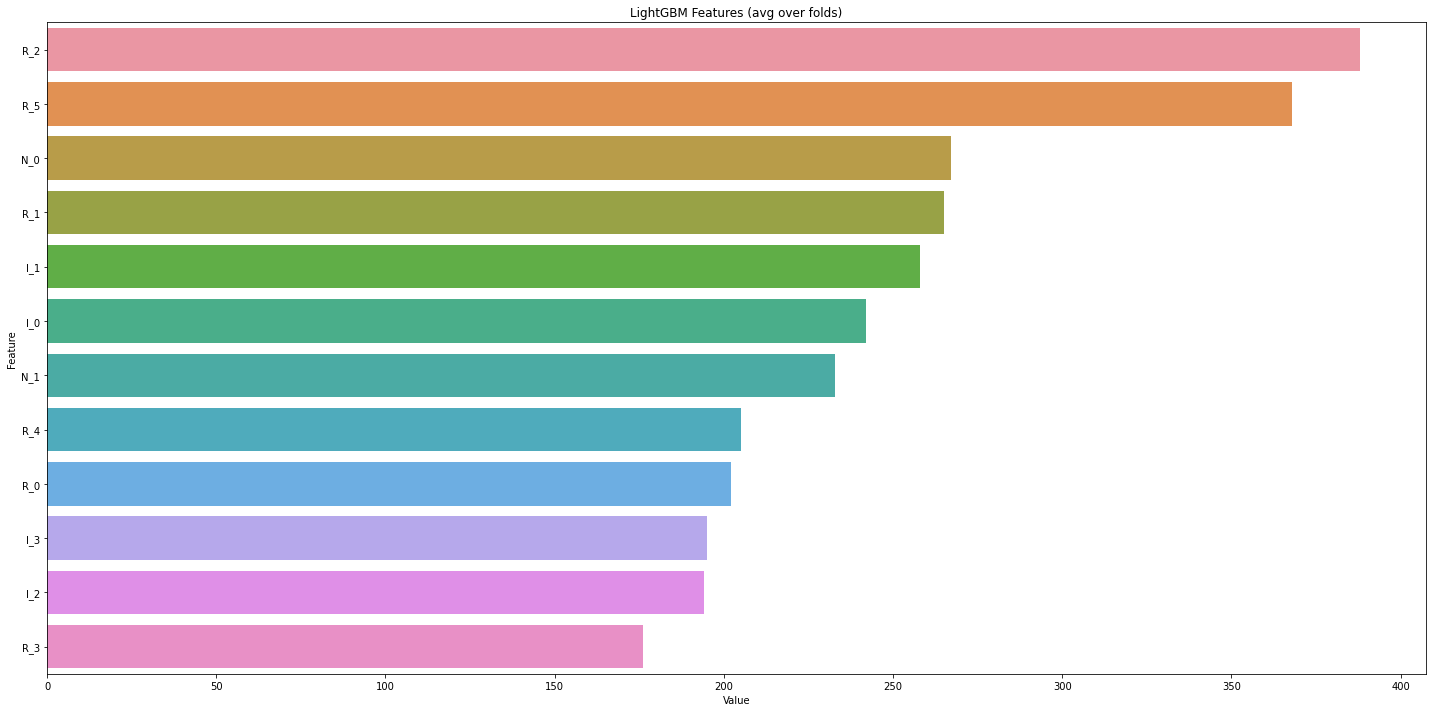

<Figure size 432x288 with 0 Axes>

In [6]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances.png')

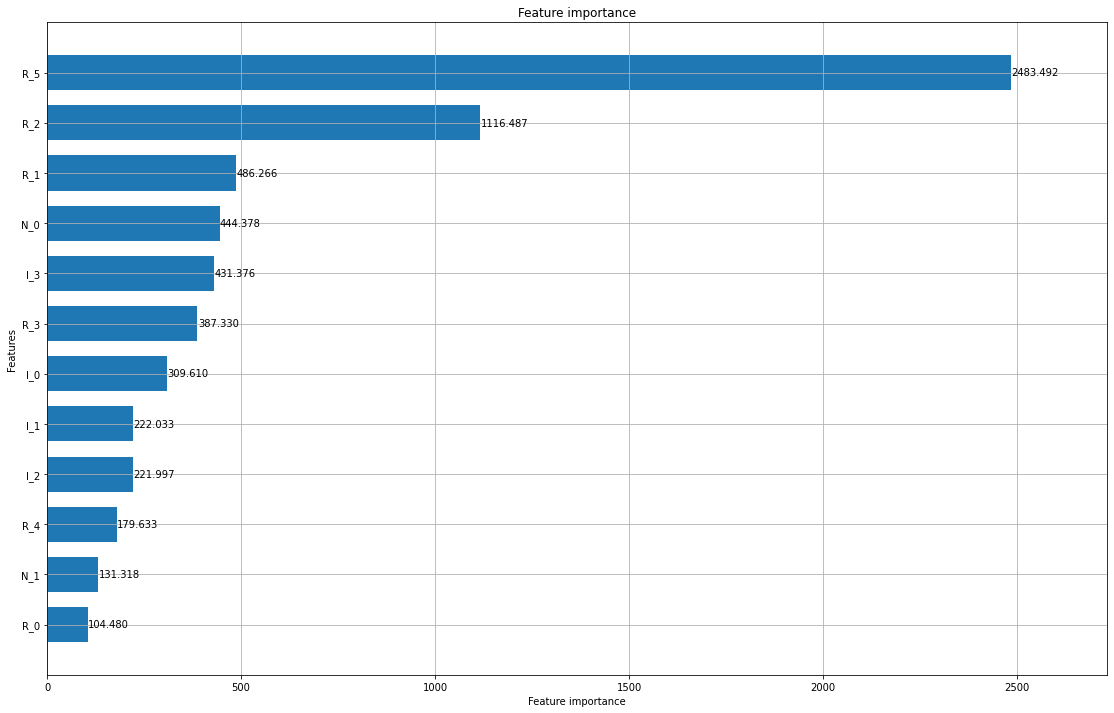

In [7]:
plot_importance(
    clf, 
    height=0.7,
    title='Feature importance', 
    xlabel='Feature importance', 
    ylabel='Features', 
    importance_type='gain', 
    grid=True, 
    precision=3,
    figsize=(19, 12)
);

# Permutation Importance/Mean decrease accuracy (MDA)
`Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS) method.`

#### Pros:
* First, it fits a classifier; 
* Second, it derives its performance OOS according to some performance score (f1, accuracy, negative log-loss, etc.); 
* third, it permutates each column of the features matrix (X), one column at a time, deriving the performance OOS after each column’s permutation. 

`The importance of a feature is a function of the loss in performance caused by its column’s permutation.`

#### Cons:
* When two important features share information, shuffling one may not result in a material reduction in model performance:
    - MDA may wrongly dismiss one or both as uninformed
* Typically MDA is more robust to substitution effects than p-values (see right plot), however this is a potential vulnerability
    - One possibility is to shuffle together all features with mutual information

# Single Feature Importance (SFI)
`
Single feature importance (SFI) is a cross-section predictive-importance (out-of- sample) method. It computes the OOS performance score of each feature in isolation.`
* This method can be applied to any classifier, not only tree-based classifiers.
* SFI is not limited to accuracy as the sole performance score.
* Unlike MDI and MDA, no substitution effects take place, since only one feature is taken into consideration at a time.
* Like MDA, it can conclude that all features are unimportant, because perfomance is evaluated via OOS CV.

# Clustered Feature Importance (CFI)
* `Apply a single-linkage agglomerative clustering algorithm on a distance matrix:`
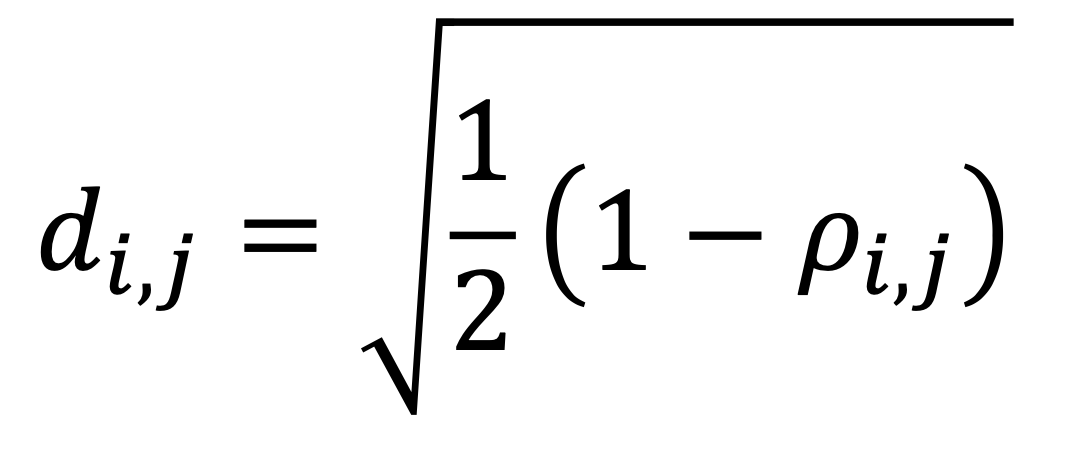

* `Base the distance on correlation, because the substitution effect is linear`
* `Instead of shuffling each variable individually, shuffle together all variables within a cluster`
* `Clustered MDA gives the right answer:`
   - All informed and redundant features are important
   - N_0 and N_1 have zero contribution to the model’s performance
   
#### Pros:
- MDA decouples the specification search from the significance search
- The clusters are not multicollinear


# Mutual Information/Informatio Gain (MI)

`Information Gain, or IG for short, measures the reduction in entropy or surprise by splitting a dataset according to a given value of a random variable.`

`A larger information gain suggests a lower entropy group or groups of samples, and hence less surprise. You might recall that information quantifies how surprising an event is in bits. Lower probability events have more information, higher probability events have less information. Entropy quantifies how much information there is in a random variable, or more specifically its probability distribution. A skewed distribution has a low entropy, whereas a distribution where events have equal probability has a larger entropy.`

`In information theory, we like to describe the “surprise” of an event. Low probability events are more surprising therefore have a larger amount of information. Whereas probability distributions where the events are equally likely are more surprising and have larger entropy.`

* Skewed Probability Distribution (unsurprising): Low entropy.
* Balanced Probability Distribution (surprising): High entropy.

In [ ]:
df, imp = compute_feature_importance(
        X,
        y,
        cv,
        f1_score,
        clf=clf,
        methods=["MDA", "SFI", "MDI", "MI", "CFI", "SHAP"],
)

MDA
SFI
MDI
MI
CFI
SHAP


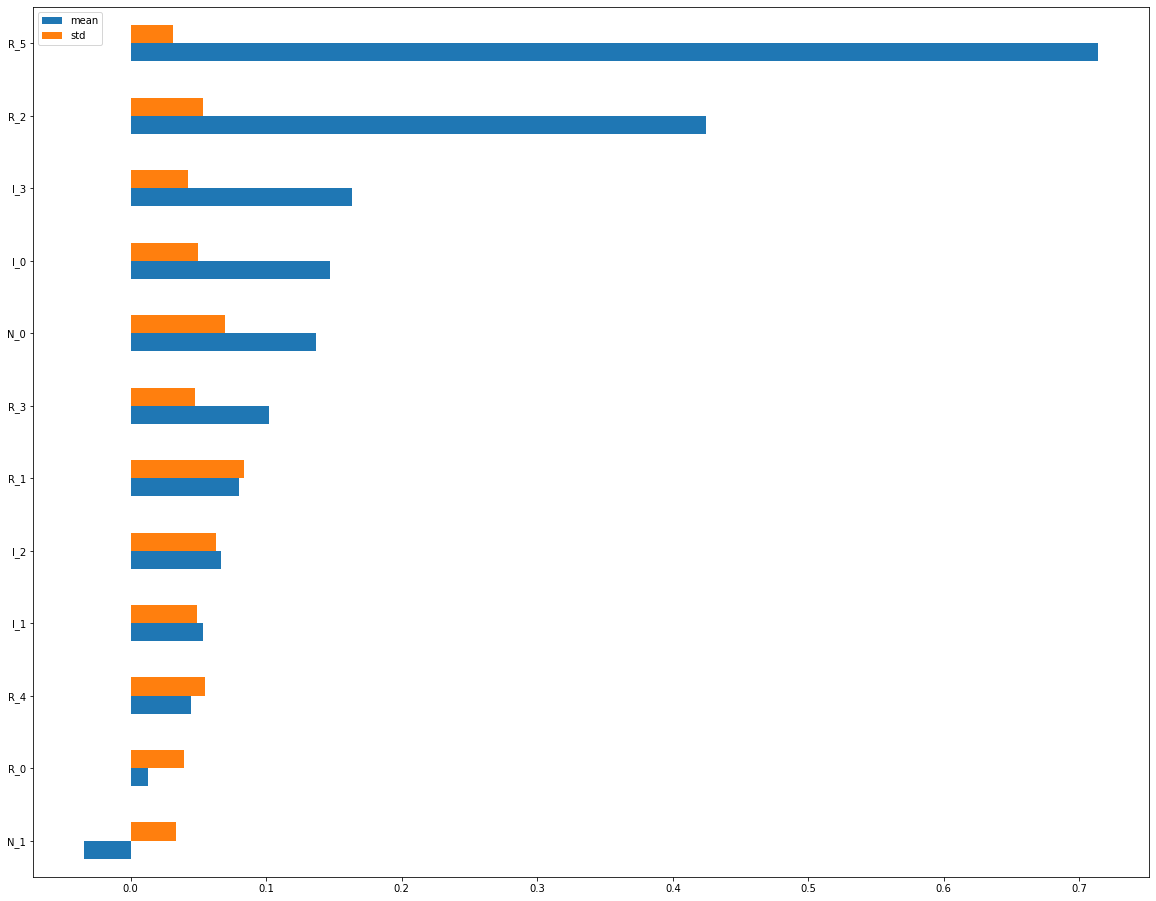

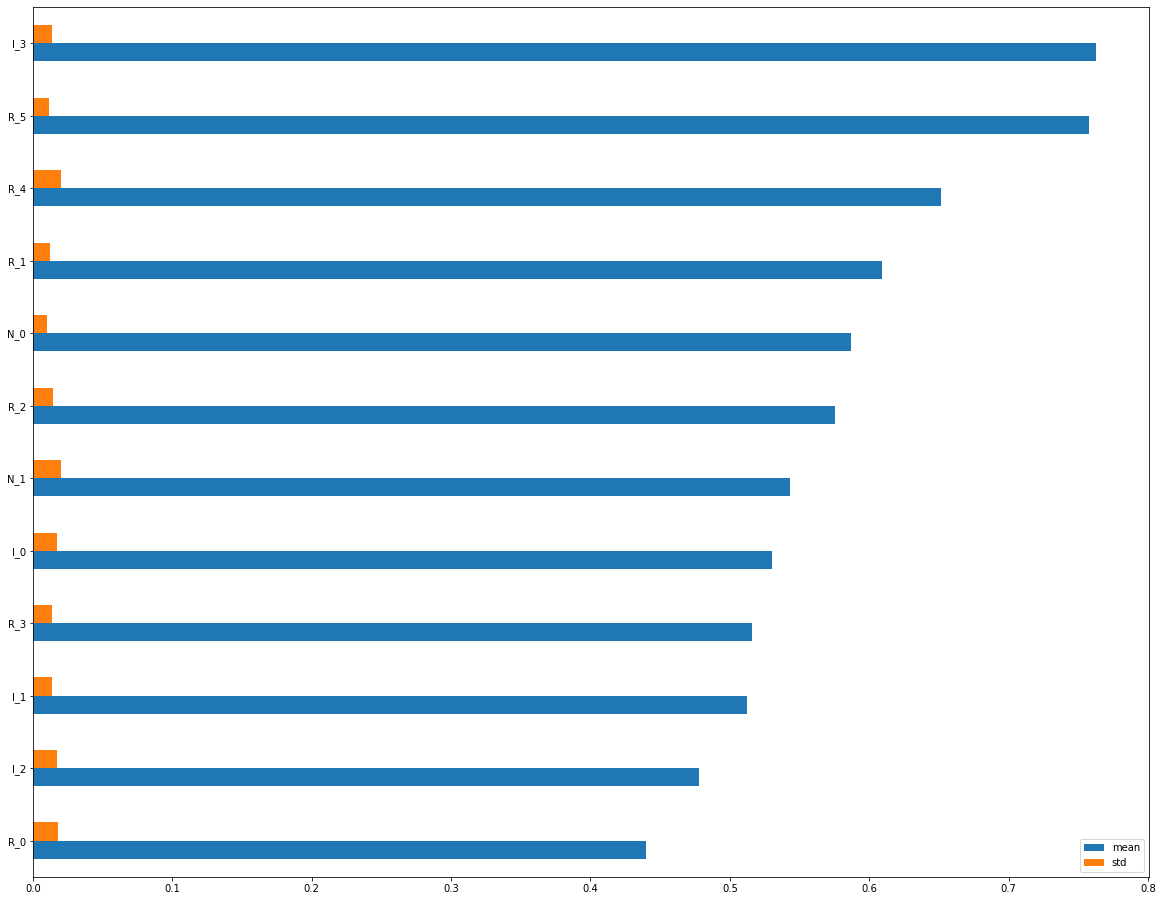

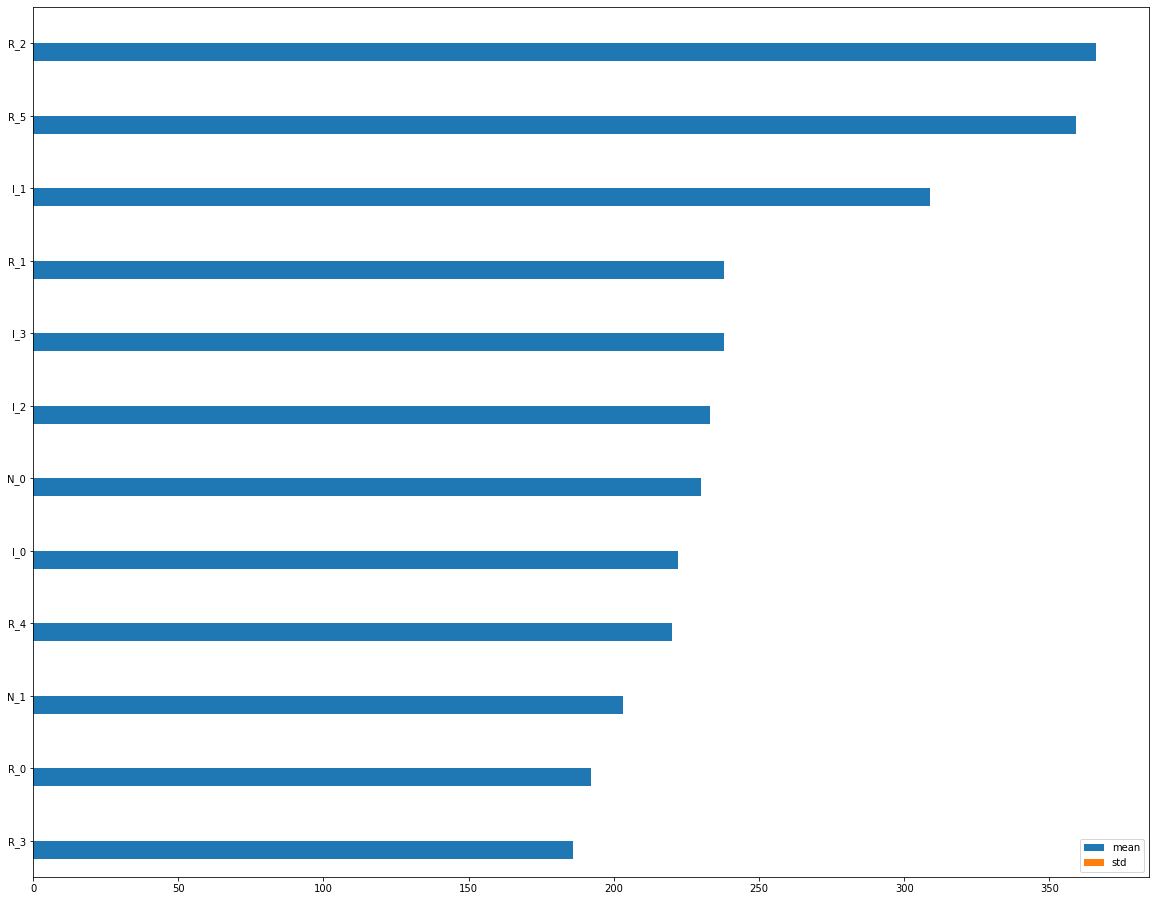

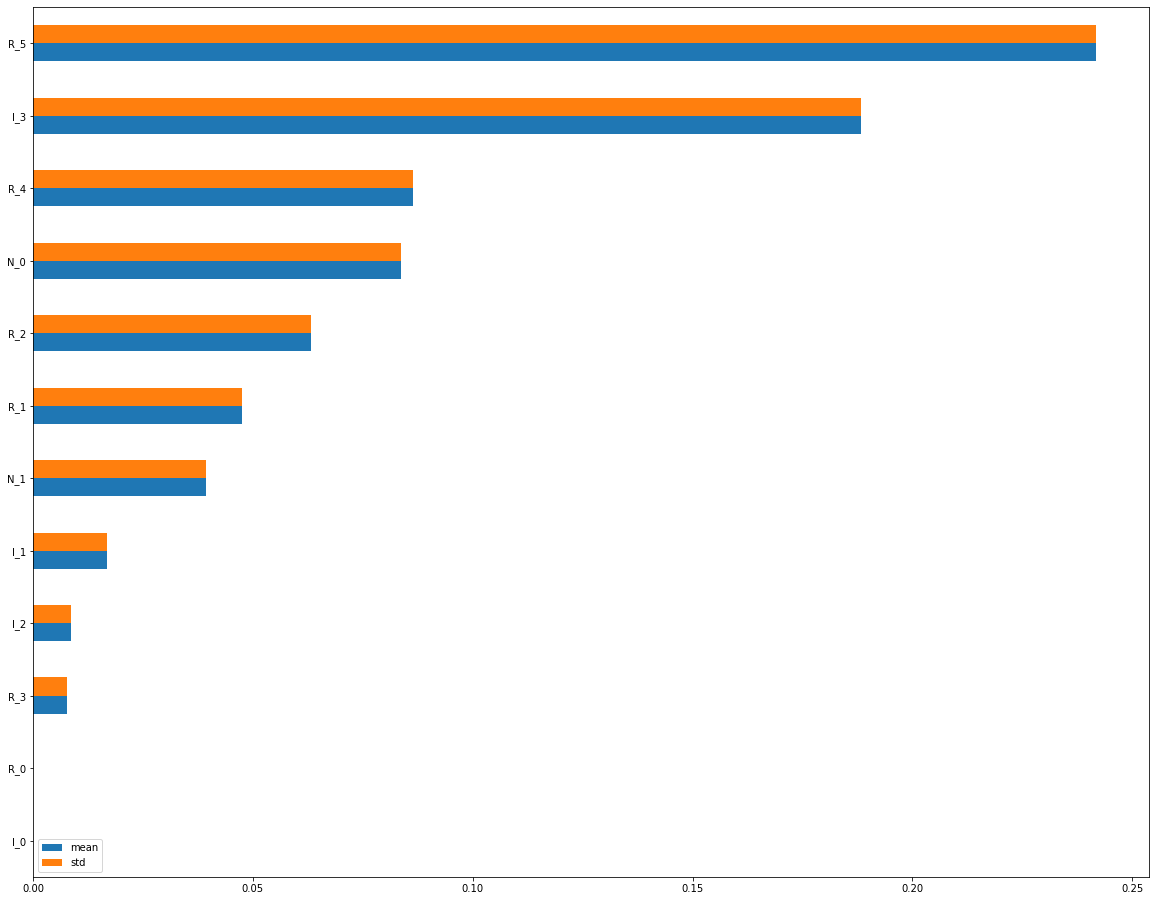

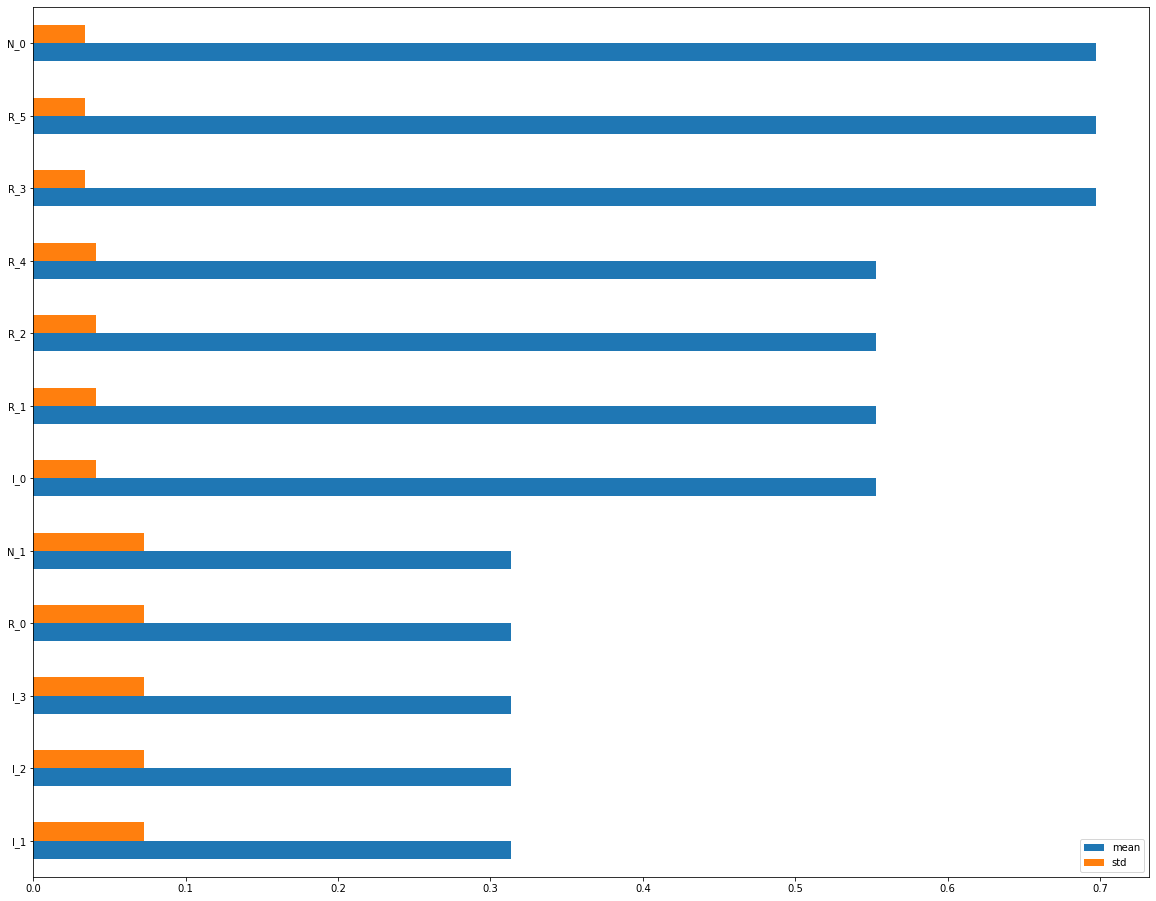

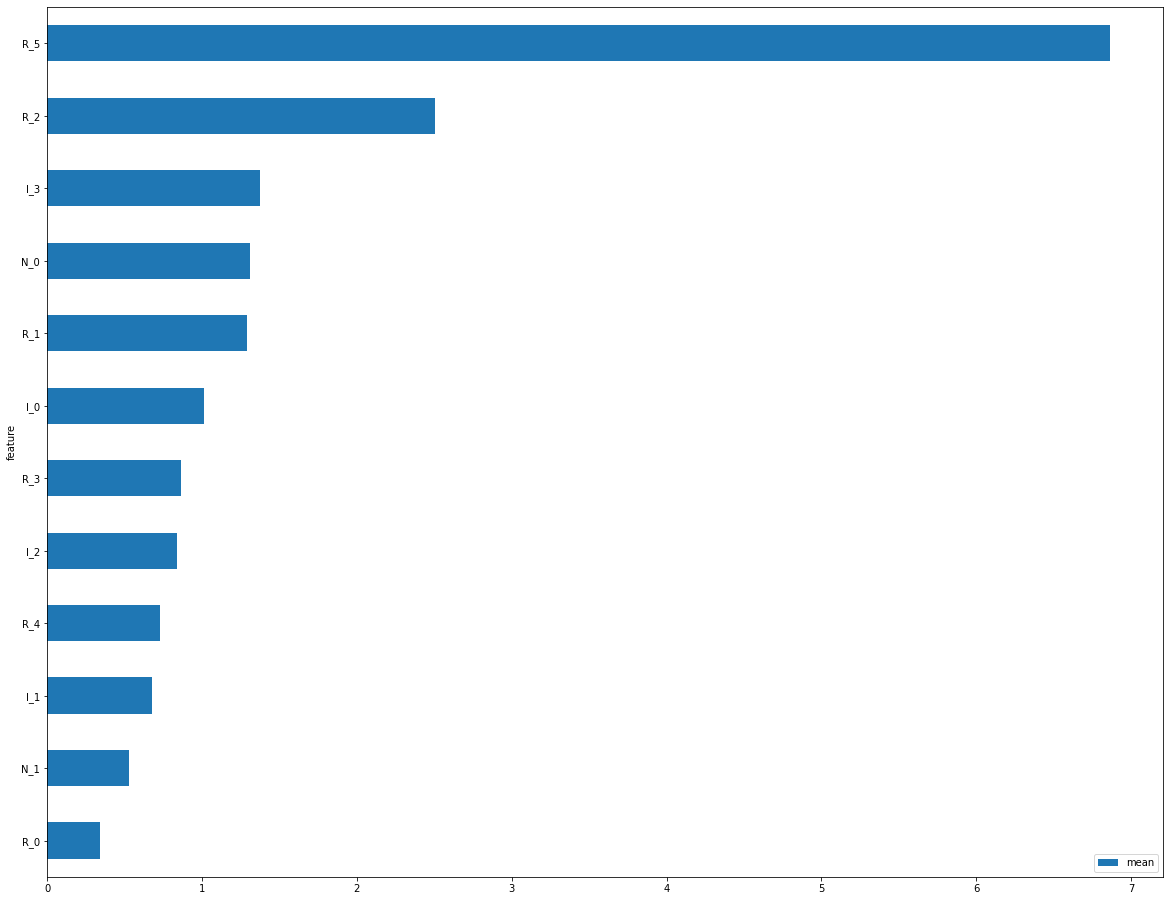

In [9]:
for name_i, importance_i in zip(df['method'], imp):
    print(name_i)
    importance_i.sort_values('mean').plot.barh(figsize=(20, 16))

In [10]:
importances = df.drop(columns='oos', axis=1).set_index('method')

In [11]:
importances.mean().sort_values(ascending=False)

R_5    0.231851
R_2    0.121770
I_3    0.106687
N_0    0.087872
R_4    0.072248
R_1    0.072081
I_0    0.062347
R_3    0.060602
I_1    0.052602
I_2    0.048373
N_1    0.043448
R_0    0.034296
dtype: float64

In [12]:
importances.median().sort_values(ascending=False)

R_5    0.214195
R_2    0.108169
R_4    0.083495
I_3    0.080918
N_0    0.080553
R_1    0.074983
I_0    0.074286
R_3    0.056877
N_1    0.051851
I_2    0.049557
I_1    0.045158
R_0    0.036029
dtype: float64

In [13]:
importances.std().sort_values(ascending=False)

R_5    0.129076
I_3    0.067919
R_2    0.050561
R_3    0.035759
R_4    0.034406
N_1    0.034225
I_0    0.032942
I_1    0.031184
R_0    0.029280
I_2    0.024172
N_0    0.020385
R_1    0.019621
dtype: float64